# FDA Recalls Data Preprocessing
- This notebook preprocesses the FDA recall data to create the final dataset for modeling

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
# Import NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
import nltk
from nltk.corpus import stopwords
import re

# NLTK resources
nltk.download('stopwords', quiet=True)

True

In [2]:
# Load the data
file_path = '../data/recalls_details.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Display basic information
print(f"Original data shape: {df.shape}")
print("\nColumn names:")
print(df.columns.tolist())

Original data shape: (95082, 17)

Column names:
['FEI Number', 'Recalling Firm Name', 'Product Type', 'Product Classification', 'Status', 'Distribution Pattern', 'Recalling Firm City', 'Recalling Firm State', 'Recalling Firm Country', 'Center Classification Date', 'Reason for Recall', 'Product Description', 'Event ID', 'Event Classification', 'Product ID', 'Center', 'Recall Details']


In [4]:
# Create a copy of the original dataframe to work with
df_processed = df.copy()

# Step 1: Feature engineering for 'Center Classification Date'

In [5]:
# Confirm datetime format
df_processed['Center Classification Date'] = pd.to_datetime(df_processed['Center Classification Date'], errors='coerce')

In [6]:
# Extract temporal features
df_processed['Classification Year'] = df_processed['Center Classification Date'].dt.year
df_processed['Classification Month'] = df_processed['Center Classification Date'].dt.month
df_processed['Classification Day'] = df_processed['Center Classification Date'].dt.day
df_processed['Classification DayOfWeek'] = df_processed['Center Classification Date'].dt.dayofweek

print("Created temporal features from 'Center Classification Date'")
print("Preview of temporal features:")
display(df_processed[['Classification Year', 'Classification Month', 'Classification Day', 'Classification DayOfWeek']].head())

Created temporal features from 'Center Classification Date'
Preview of temporal features:


,Classification Year,Classification Month,Classification Day,Classification DayOfWeek
0,2025,2,21,4
1,2025,2,21,4
2,2025,2,21,4
3,2025,2,21,4
4,2025,2,21,4


# Step 2: Verify relationship between Center and Product Type

In [7]:
center_product_crosstab = pd.crosstab(df['Center'], df['Product Type'])
print("\nCrosstab of Center vs Product Type (from original data):")
print(center_product_crosstab)


Crosstab of Center vs Product Type (from original data):
Product Type  Biologics  Devices  Drugs  Food/Cosmetics  Tobacco  Veterinary
Center                                                                      
CBER              12051        0      0               0        0           0
CDER                  0        0  16702               0        0           0
CDRH                  0    35475      0               0        0           0
CFSAN                 0        0      0           27435        0           0
CTP                   0        0      0               0        9           0
CVM                   0        0      0               0        0        3410


# Step 3: Feature engineering for 'Recalling Firm Name' and 'Distribution Pattern'

In [8]:
# Check cardinality
print(f"Cardinality of 'Recalling Firm Name': {df_processed['Recalling Firm Name'].nunique()}")
print(f"Cardinality of 'Distribution Pattern': {df_processed['Distribution Pattern'].nunique()}")

Cardinality of 'Recalling Firm Name': 9927
Cardinality of 'Distribution Pattern': 20312


Frequency-based encoding for 'Recalling Firm Name'

In [9]:
# Count how many times each firm has issued a recall
firm_counts = df_processed.groupby('Recalling Firm Name').size().reset_index(name='Firm_Recall_Count')

# Calculate class proportions for each firm
for class_type in df_processed['Event Classification'].unique():
    class_prop = df_processed.groupby('Recalling Firm Name')['Event Classification'].apply(
        lambda x: (x == class_type).mean()
    ).reset_index(name=f'Firm_Prop_{class_type.replace(" ", "_")}')
    
    # Merge back to firm_counts
    firm_counts = pd.merge(firm_counts, class_prop, on='Recalling Firm Name', how='left')

In [10]:
# Add categorical size based on recall frequency
try:
    # Check if we have enough unique values for 5 bins
    unique_count_values = firm_counts['Firm_Recall_Count'].nunique()
    if unique_count_values >= 5:
        firm_counts['Firm_Size_Category'] = pd.qcut(
            firm_counts['Firm_Recall_Count'], 
            q=5, 
            labels=['Very Low Volume', 'Low Volume', 'Medium Volume', 'High Volume', 'Very High Volume'],
            duplicates='drop'  # Handle any duplicate bin edges
        )
    else:
        # Not enough unique values for 5 quantiles
        firm_counts['Firm_Size_Category'] = pd.cut(
            firm_counts['Firm_Recall_Count'],
            bins=[0, 1, 2, 5, 10, float('inf')],
            labels=['Very Low Volume', 'Low Volume', 'Medium Volume', 'High Volume', 'Very High Volume']
        )
except ValueError:
    # If either method fails, use a simple categorical approach
    firm_counts['Firm_Size_Category'] = 'Medium Volume'  # Default value
    
    # Assign categories based on count thresholds
    firm_counts.loc[firm_counts['Firm_Recall_Count'] == 1, 'Firm_Size_Category'] = 'Very Low Volume'
    firm_counts.loc[(firm_counts['Firm_Recall_Count'] > 1) & (firm_counts['Firm_Recall_Count'] <= 3), 'Firm_Size_Category'] = 'Low Volume'
    firm_counts.loc[(firm_counts['Firm_Recall_Count'] > 3) & (firm_counts['Firm_Recall_Count'] <= 10), 'Firm_Size_Category'] = 'Medium Volume'
    firm_counts.loc[(firm_counts['Firm_Recall_Count'] > 10) & (firm_counts['Firm_Recall_Count'] <= 30), 'Firm_Size_Category'] = 'High Volume'
    firm_counts.loc[firm_counts['Firm_Recall_Count'] > 30, 'Firm_Size_Category'] = 'Very High Volume'

Frequency-based encoding for 'Distribution Pattern'

In [11]:
# Handle missing values in Distribution Pattern
df_processed['Distribution Pattern'] = df_processed['Distribution Pattern'].fillna('Unknown')
distribution_counts = df_processed.groupby('Distribution Pattern').size().reset_index(name='Distribution_Pattern_Count')

In [12]:
# Calculate class proportions for each distribution pattern
for class_type in df_processed['Event Classification'].unique():
    class_prop = df_processed.groupby('Distribution Pattern')['Event Classification'].apply(
        lambda x: (x == class_type).mean()
    ).reset_index(name=f'Distribution_Prop_{class_type.replace(" ", "_")}')
    
    # Merge back to distribution_counts
    distribution_counts = pd.merge(distribution_counts, class_prop, on='Distribution Pattern', how='left')

In [13]:
# Merge the new features back to the dataframe
df_processed = pd.merge(df_processed, firm_counts, on='Recalling Firm Name', how='left')
df_processed = pd.merge(df_processed, distribution_counts, on='Distribution Pattern', how='left')

print("Encoded high cardinality variables with frequency-based features")
print("Preview of new features:")
display(df_processed[['Firm_Recall_Count', 'Firm_Prop_Class_I', 'Firm_Size_Category', 
                     'Distribution_Pattern_Count', 'Distribution_Prop_Class_I']].head())

Encoded high cardinality variables with frequency-based features
Preview of new features:


,Firm_Recall_Count,Firm_Prop_Class_I,Firm_Size_Category,Distribution_Pattern_Count,Distribution_Prop_Class_I
0,1,1.0,Very Low Volume,1,1.000000
1,18,0.0,High Volume,4894,0.144054
2,18,0.0,High Volume,4894,0.144054
3,18,0.0,High Volume,4894,0.144054
4,18,0.0,High Volume,4894,0.144054


# Step 4: Feature engineering for geographical variables (city and state)

Create state-level aggregation features

In [14]:
# count the number of recalls associated with each state
state_counts = df_processed.groupby('Recalling Firm State').size().reset_index(name='State_Recall_Count')

# Calculate class proportions by state for each classification type
for class_type in df_processed['Event Classification'].unique():
    class_name = class_type.replace(' ', '_')
    state_prop = df_processed.groupby('Recalling Firm State')['Event Classification'].apply(
        lambda x: (x == class_type).mean()
    ).reset_index(name=f'State_Prop_{class_name}')
    
    # Merge back to state_counts
    state_counts = pd.merge(state_counts, state_prop, on='Recalling Firm State', how='left')

Create city-level features with aggregation to reduce cardinality

In [15]:
# count the number of recalls associated with each city
city_counts = df_processed.groupby('Recalling Firm City').size().reset_index(name='City_Recall_Count')

# Categorize cities into frequency buckets
try:
    # First, check if we have enough unique values for 5 bins
    unique_count_values = city_counts['City_Recall_Count'].nunique()
    if unique_count_values >= 5:
        city_counts['City_Size_Category'] = pd.qcut(
            city_counts['City_Recall_Count'], 
            q=5, 
            labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large'],
            duplicates='drop'
        )
    else:
        # Not enough unique values for 5 quantiles
        city_counts['City_Size_Category'] = pd.cut(
            city_counts['City_Recall_Count'],
            bins=[0, 1, 2, 5, 10, float('inf')],
            labels=['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
        )
except ValueError:
    # If either method fails, use a simple categorical approach
    city_counts['City_Size_Category'] = 'Medium'  # Default value
    
    # Assign categories based on count thresholds
    city_counts.loc[city_counts['City_Recall_Count'] == 1, 'City_Size_Category'] = 'Very Small'
    city_counts.loc[(city_counts['City_Recall_Count'] > 1) & (city_counts['City_Recall_Count'] <= 3), 'City_Size_Category'] = 'Small'
    city_counts.loc[(city_counts['City_Recall_Count'] > 3) & (city_counts['City_Recall_Count'] <= 10), 'City_Size_Category'] = 'Medium'
    city_counts.loc[(city_counts['City_Recall_Count'] > 10) & (city_counts['City_Recall_Count'] <= 30), 'City_Size_Category'] = 'Large'
    city_counts.loc[city_counts['City_Recall_Count'] > 30, 'City_Size_Category'] = 'Very Large'

Create location-based risk scores for all classes

In [16]:
# Calculate proportion of recall events that belong to a specific classification for ea city
city_class_props = {}
for class_type in df_processed['Event Classification'].unique():
    class_name = class_type.replace(' ', '_')
    city_risk = df_processed.groupby('Recalling Firm City')['Event Classification'].apply(
        lambda x: (x == class_type).mean()
    ).reset_index(name=f'City_{class_name}_Risk')
    city_class_props[class_name] = city_risk

In [17]:
# Merge geographical features to df_processed
df_processed = pd.merge(df_processed, state_counts, on='Recalling Firm State', how='left')
df_processed = pd.merge(df_processed, city_counts, on='Recalling Firm City', how='left')

In [18]:
# Merge city risk scores
for class_name, risk_df in city_class_props.items():
    df_processed = pd.merge(df_processed, risk_df, on='Recalling Firm City', how='left')

Fill missing values with overall proportions where appropriate

In [19]:
# Fill in missing city risk values
for class_type in df_processed['Event Classification'].unique():
    class_name = class_type.replace(' ', '_')
    overall_prop = df_processed['Event Classification'].value_counts(normalize=True).get(class_type, 0)
    df_processed.fillna({f'City_{class_name}_Risk': overall_prop}, inplace=True)

In [20]:
# Fill any other missing numerical values
numerical_cols = df_processed.select_dtypes(include=['number']).columns
for col in numerical_cols:
    if df_processed[col].isna().any():
        if col.startswith('City_') or col.startswith('State_'):
            df_processed[col].fillna(0, inplace=True)

Create regional features

In [21]:
# Define regions based on states
northeast = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 
             'New York', 'New Jersey', 'Pennsylvania']
midwest = ['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'Minnesota', 
           'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas']
south = ['Delaware', 'Maryland', 'Virginia', 'West Virginia', 'Kentucky', 'North Carolina', 
         'South Carolina', 'Tennessee', 'Georgia', 'Florida', 'Alabama', 'Mississippi', 
         'Arkansas', 'Louisiana', 'Texas', 'Oklahoma']
west = ['Montana', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'Utah', 
        'Nevada', 'California', 'Oregon', 'Washington', 'Alaska', 'Hawaii']

In [22]:
# Function to map states to regions
def get_region(state):
    if state in northeast:
        return 'Northeast'
    elif state in midwest:
        return 'Midwest'
    elif state in south:
        return 'South'
    elif state in west:
        return 'West'
    else:
        return 'Other'

In [23]:
# Apply the mapping function to create the region column
df_processed['Region'] = df_processed['Recalling Firm State'].apply(get_region)

In [24]:
# Create one-hot encoded region features
region_dummies = pd.get_dummies(df_processed['Region'], prefix='Region')
df_processed = pd.concat([df_processed, region_dummies], axis=1)

In [25]:
# new geographical features
geo_feature_cols = [col for col in df_processed.columns if col.startswith(('State_', 'City_', 'Region_'))]
display(df_processed[geo_feature_cols].head())

,State_Recall_Count,State_Prop_Class_I,State_Prop_Class_II,State_Prop_Class_III,City_Recall_Count,City_Size_Category,City_Class_I_Risk,City_Class_II_Risk,City_Class_III_Risk,Region_Midwest,Region_Northeast,Region_Other,Region_South,Region_West
0,1474,0.147897,0.778833,0.073270,446,Very Large,0.266816,0.690583,0.042601,False,False,False,False,True
1,4559,0.148936,0.797543,0.053521,308,Very Large,0.029221,0.827922,0.142857,False,True,False,False,False
2,4559,0.148936,0.797543,0.053521,308,Very Large,0.029221,0.827922,0.142857,False,True,False,False,False
3,4559,0.148936,0.797543,0.053521,308,Very Large,0.029221,0.827922,0.142857,False,True,False,False,False
4,4559,0.148936,0.797543,0.053521,308,Very Large,0.029221,0.827922,0.142857,False,True,False,False,False


# Step 5: Feature engineering for 'Recalling Firm Country'

Preview of new country feature

In [26]:
# Create binary US indicator
df_processed['Is_US'] = (df_processed['Recalling Firm Country'] == 'United States').astype(int)

display(df_processed[['Is_US']].head())

,Is_US
0,1
1,1
2,1
3,1
4,1


# Step 6: Create dummy variables for remaining categorical features

Create dummy variables for categorical features

In [27]:
# Product Classification
product_class_dummies = pd.get_dummies(df_processed['Product Classification'], prefix='ProdClass', drop_first=True)
df_processed = pd.concat([df_processed, product_class_dummies], axis=1)

In [28]:
# Product Type
product_type_dummies = pd.get_dummies(df_processed['Product Type'], prefix='ProductType', drop_first=True)
df_processed = pd.concat([df_processed, product_type_dummies], axis=1)

In [29]:
# Status
status_dummies = pd.get_dummies(df_processed['Status'], prefix='Status', drop_first=True)
df_processed = pd.concat([df_processed, status_dummies], axis=1)

In [30]:
# Firm Size Category
firm_size_dummies = pd.get_dummies(df_processed['Firm_Size_Category'], prefix='FirmSize', drop_first=True)
df_processed = pd.concat([df_processed, firm_size_dummies], axis=1)

In [31]:
# City Size Category
city_size_dummies = pd.get_dummies(df_processed['City_Size_Category'], prefix='CitySize', drop_first=True)
df_processed = pd.concat([df_processed, city_size_dummies], axis=1)

# Step 7: Perform correlation analysis before text processing

In [32]:
# Exclude text columns (for now) and ID variables
text_cols = ['Reason for Recall', 'Product Description']
id_cols = ["FEI Number", "Event ID", "Product ID", "Recall Details"]

In [33]:
# List of columns to drop for correlation analysis (excluding text columns we'll need later)
correlation_drop_cols = [
    # ID variables
    "FEI Number", "Event ID", "Product ID", "Recall Details",
    # Original columns that have been transformed (excluding text columns)
    "Center", "Center Classification Date",
    "Recalling Firm Name", "Distribution Pattern",
    "Recalling Firm City", "Recalling Firm State", "Recalling Firm Country",
    "Product Type", "Status",
    # Intermediate columns
    "Region", "Firm_Size_Category", "City_Size_Category",
    # Original categorical columns (now encoded as dummies)
    "Product Classification",
    # Target variable - should not be included in feature correlation analysis
    "Event Classification"
]

In [34]:
# Filter to only include columns that exist
cols_to_drop_for_correlation = [col for col in correlation_drop_cols if col in df_processed.columns]

In [35]:
# Create a temporary dataframe for correlation analysis
df_for_correlation = df_processed.drop(columns=cols_to_drop_for_correlation)

In [36]:
# drop text columns for correlation analysis
df_for_correlation = df_for_correlation.drop(columns=[col for col in text_cols if col in df_for_correlation.columns])

In [37]:
df_for_correlation.shape

(95082, 43)

In [38]:
# Compute correlation matrix with numeric col only
numeric_cols = df_for_correlation.select_dtypes(include=['number', 'bool']).columns.tolist()
print(f"\nUsing {len(numeric_cols)} numeric columns for correlation analysis:")
print(numeric_cols[:10], "..." if len(numeric_cols) > 10 else "")


Using 43 numeric columns for correlation analysis:
['Classification Year', 'Classification Month', 'Classification Day', 'Classification DayOfWeek', 'Firm_Recall_Count', 'Firm_Prop_Class_I', 'Firm_Prop_Class_II', 'Firm_Prop_Class_III', 'Distribution_Pattern_Count', 'Distribution_Prop_Class_I'] ...


In [39]:
correlation_matrix = df_for_correlation.corr()

In [40]:
# Identify highly correlated features
threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append(
                (correlation_matrix.columns[i], 
                 correlation_matrix.columns[j], 
                 correlation_matrix.iloc[i, j])
            )

In [41]:
# Display highly correlated pairs
if high_corr_pairs:
    print(f"\nIdentified {len(high_corr_pairs)} highly correlated feature pairs (|r| > {threshold}):")
    for col1, col2, corr in high_corr_pairs:
        print(f"  - {col1} and {col2}: r = {corr:.3f}")
else:
    print(f"\nNo highly correlated feature pairs found (|r| > {threshold}).")


Identified 8 highly correlated feature pairs (|r| > 0.8):
  - Firm_Prop_Class_I and Firm_Prop_Class_II: r = -0.865
  - Firm_Prop_Class_I and Distribution_Prop_Class_I: r = 0.845
  - Distribution_Prop_Class_I and Distribution_Prop_Class_II: r = -0.861
  - Distribution_Prop_Class_II and ProdClass_Class II: r = 0.803
  - State_Prop_Class_I and State_Prop_Class_II: r = -0.942
  - City_Class_I_Risk and City_Class_II_Risk: r = -0.890
  - Region_Other and Is_US: r = -0.889
  - Status_Ongoing and Status_Terminated: r = -0.933


Visualize correlation matrix for key features

In [42]:
# Select a subset of important features to make the visualization manageable
if len(numeric_cols) > 25:
    # Include key product classification dummies
    prod_class_cols = [col for col in numeric_cols if col.startswith('ProdClass')][:3]
    
    # Select features with highest average absolute correlation
    corr_means = correlation_matrix.abs().mean().sort_values(ascending=False)
    top_correlated = corr_means[:15].index.tolist()
    
    # Combine interesting features
    top_features = list(set(prod_class_cols + top_correlated))[:20]
else:
    top_features = numeric_cols

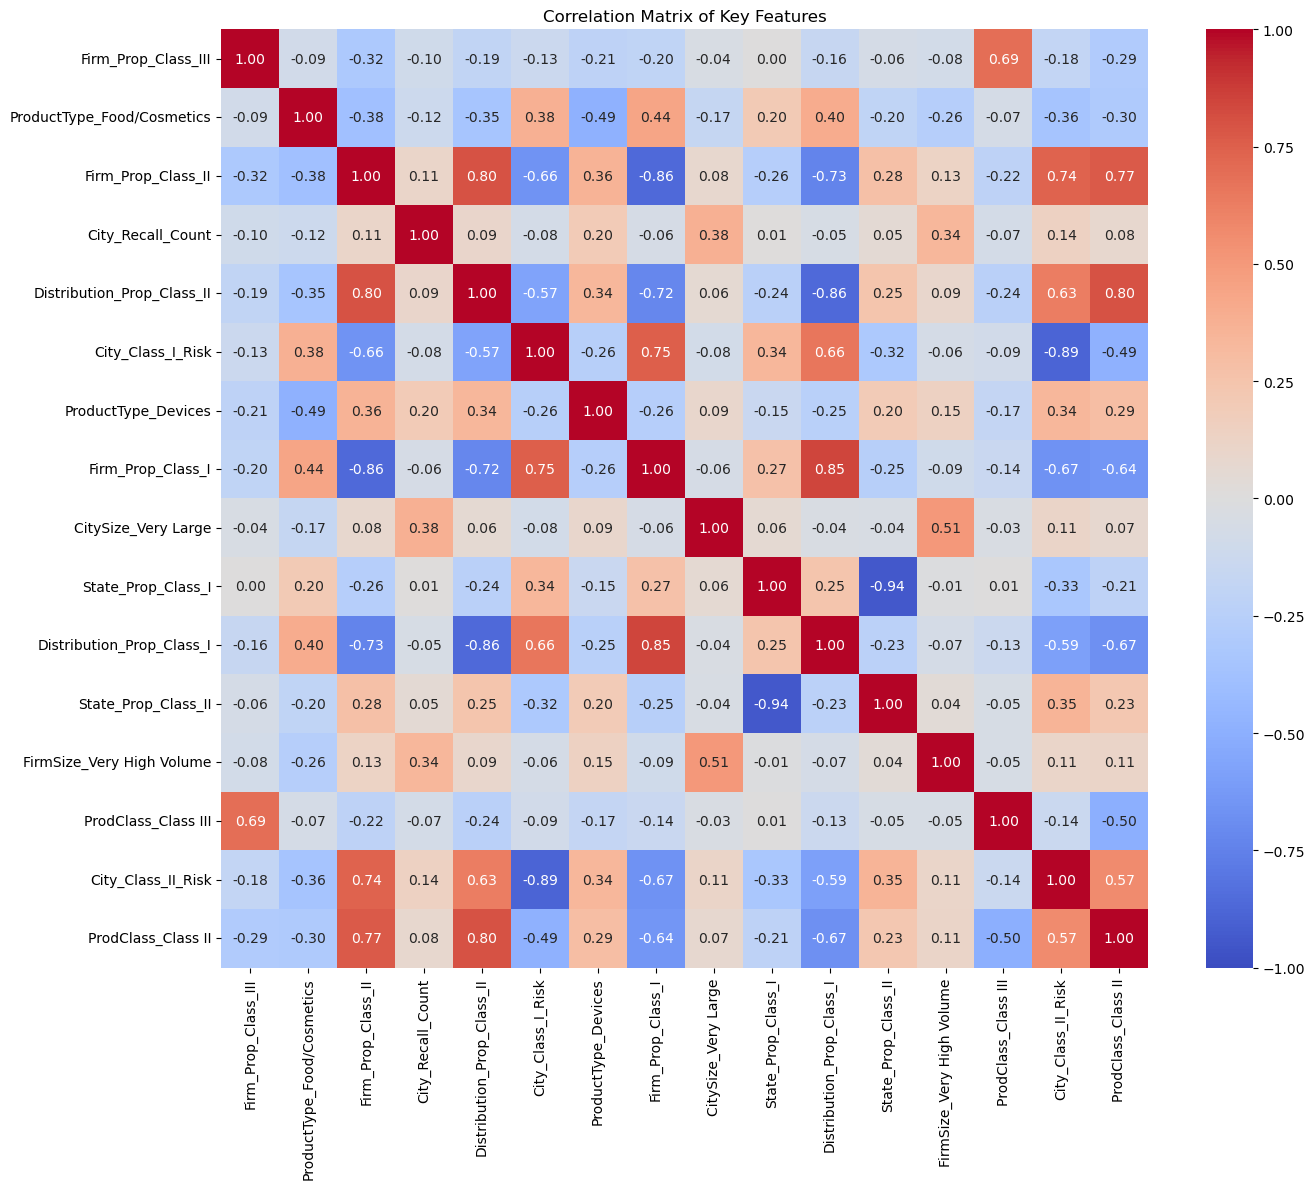

In [43]:
# Create correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix.loc[top_features, top_features], 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            vmin=-1,
            vmax=1,
            fmt='.2f')
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

# Step 8: Feature Selection

1. Address dummy variable redundancy

In [44]:
# Features to drop based on correlation analysis
features_to_drop = []

# Address dummy variable redundancy
dummy_var_groups = {
    'Status': [col for col in df_processed.columns if col.startswith('Status_')],
    'Region': [col for col in df_processed.columns if col.startswith('Region_')] + ['Is_US']
}

for group_name, group_vars in dummy_var_groups.items():
    # Ensure all variables in the group exist in the dataframe
    group_vars_in_df = [var for var in group_vars if var in df_processed.columns]
    if len(group_vars_in_df) > 1:
        # Keep first variable, drop others
        features_to_drop.extend(group_vars_in_df[1:])
        print(f"\nFrom {group_name} dummy variables: keeping {group_vars_in_df[0]}, dropping {group_vars_in_df[1:]}")


From Status dummy variables: keeping Status_Ongoing, dropping ['Status_Terminated']

From Region dummy variables: keeping Region_Midwest, dropping ['Region_Northeast', 'Region_Other', 'Region_South', 'Region_West', 'Is_US']


2. Address proportion features with natural constraints

In [45]:
# Group column names by prefix
proportion_groups = {
    'Firm_Prop': [col for col in df_processed.columns if col.startswith('Firm_Prop_')],
    'Distribution_Prop': [col for col in df_processed.columns if col.startswith('Distribution_Prop_')],
    'State_Prop': [col for col in df_processed.columns if col.startswith('State_Prop_')],
    'City_Class_Risk': [col for col in df_processed.columns if col.startswith('City_Class_') and col.endswith('_Risk')]
}

for group_name, group_vars in proportion_groups.items():
    # Ensure all variables in the group exist in the dataframe
    group_vars_in_df = [var for var in group_vars if var in df_processed.columns]
    if len(group_vars_in_df) > 1:
        # Keep Class I proportion, drop others
        class_i_var = next((var for var in group_vars_in_df if 'Class_I' in var), None)
        if class_i_var:
            to_drop = [var for var in group_vars_in_df if var != class_i_var]
            features_to_drop.extend(to_drop)
            print(f"\nFrom {group_name} proportions: keeping {class_i_var}, dropping {to_drop}")
        else:
            print(f"\nNo Class I proportion found in {group_name} group: {group_vars_in_df}")


From Firm_Prop proportions: keeping Firm_Prop_Class_I, dropping ['Firm_Prop_Class_II', 'Firm_Prop_Class_III']

From Distribution_Prop proportions: keeping Distribution_Prop_Class_I, dropping ['Distribution_Prop_Class_II', 'Distribution_Prop_Class_III']

From State_Prop proportions: keeping State_Prop_Class_I, dropping ['State_Prop_Class_II', 'State_Prop_Class_III']

From City_Class_Risk proportions: keeping City_Class_I_Risk, dropping ['City_Class_II_Risk', 'City_Class_III_Risk']


In [46]:
# Remove duplicate entries and ensure all features exist
features_to_drop = list(set(features_to_drop))
features_to_drop = [f for f in features_to_drop if f in df_processed.columns]

4. Apply Variance Thresholding to remove low-variance features

In [47]:
# Identify categorical columns to exclude
categorical_columns = [
    col for col in df_processed.columns 
    if col.startswith(('ProdClass_', 'ProductType_', 'Status_', 'FirmSize_', 'CitySize_', 'Region_'))
]

In [48]:
# Create a copy of the dataframe with numeric features (exclude categorical columns)
variance_df = df_processed.drop(columns=categorical_columns + ['Product Classification', 'Event Classification'])
numeric_cols = variance_df.select_dtypes(include=['number']).columns.tolist()

In [49]:
# Apply variance threshold for numeric cols
if numeric_cols:
    # Set a low threshold to only remove constant or near-constant features
    var_threshold = 0.01
    selector = VarianceThreshold(threshold=var_threshold)
    
    try:
        # Fit the selector to find low-variance features
        selector.fit(variance_df[numeric_cols])
        
        # Get features to keep
        low_variance_features = [numeric_cols[i] for i, variance in enumerate(selector.variances_) if variance <= var_threshold]
        
        if low_variance_features:
            print(f"\nIdentified {len(low_variance_features)} low-variance features (variance <= {var_threshold}):")
            for feature in low_variance_features:
                print(f"  - {feature}: variance = {selector.variances_[numeric_cols.index(feature)]:.6f}")
                if feature not in features_to_drop and feature in df_processed.columns:
                    features_to_drop.append(feature)
        else:
            print(f"\nNo low-variance features found (threshold: {var_threshold})")
    except Exception as e:
        print(f"Error in variance thresholding: {e}")
        print("Skipping variance-based feature selection")


Identified 1 low-variance features (variance <= 0.01):
  - State_Prop_Class_III: variance = 0.001283


5. Drop the selected features to reduce multicollinearity and remove uninformative features"

In [50]:
df_processed_reduced = df_processed.drop(columns=features_to_drop)

In [51]:
# Show dimension reduction results
print(f"\nDimension reduction summary:")
print(f"  - Original shape: {df_processed.shape}")
print(f"  - Reduced shape: {df_processed_reduced.shape}")
print(f"  - Features removed: {len(features_to_drop)}")


Dimension reduction summary:
  - Original shape: (95082, 63)
  - Reduced shape: (95082, 49)
  - Features removed: 14


In [52]:
# Update df_processed to use the reduced feature set
df_processed = df_processed_reduced

# Step 9: FINAL CLEANUP SECTION - Drop all original columns now that feature engineering is complete

In [53]:
# Identify original columns to drop
original_cols_to_drop = [
    # ID variables
    "FEI Number", "Event ID", "Product ID", "Recall Details",
    # Original columns that have been transformed
    "Center", "Center Classification Date",
    "Recalling Firm Name", "Distribution Pattern",
    "Recalling Firm City", "Recalling Firm State", "Recalling Firm Country",
    "Product Type", "Status",
    # Text columns that will be processed separately for the hybrid dataset
    "Reason for Recall", "Product Description",
    # Original categorical column now fully dummy encoded
    "Product Classification",
    # Intermediate columns
    "Region", "Firm_Size_Category", "City_Size_Category"
]

# Filter to only include columns that exist
cols_to_drop = [col for col in original_cols_to_drop if col in df_processed.columns]

# Drop the columns
df_processed_baseline = df_processed.drop(columns=cols_to_drop)
print("\nCleaned up original and intermediate columns:")
print(f"Dropped columns: {cols_to_drop}")
print(f"Baseline shape: {df_processed_baseline.shape}")


Cleaned up original and intermediate columns:
Dropped columns: ['FEI Number', 'Event ID', 'Product ID', 'Recall Details', 'Center', 'Center Classification Date', 'Recalling Firm Name', 'Distribution Pattern', 'Recalling Firm City', 'Recalling Firm State', 'Recalling Firm Country', 'Product Type', 'Status', 'Reason for Recall', 'Product Description', 'Product Classification', 'Region', 'Firm_Size_Category', 'City_Size_Category']
Baseline shape: (95082, 30)


In [54]:
# Preview Baseline dataset columns
print("\nBaseline dataset columns:")
print(df_processed_baseline.columns.tolist())


Baseline dataset columns:
['Event Classification', 'Classification Year', 'Classification Month', 'Classification Day', 'Classification DayOfWeek', 'Firm_Recall_Count', 'Firm_Prop_Class_I', 'Distribution_Pattern_Count', 'Distribution_Prop_Class_I', 'State_Recall_Count', 'State_Prop_Class_I', 'City_Recall_Count', 'City_Class_I_Risk', 'Region_Midwest', 'ProdClass_Class II', 'ProdClass_Class III', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'FirmSize_Low Volume', 'FirmSize_Medium Volume', 'FirmSize_Very High Volume', 'FirmSize_Very Low Volume', 'CitySize_Medium', 'CitySize_Small', 'CitySize_Very Large', 'CitySize_Very Small']


In [55]:
# Save baseline dataset
df_processed_baseline.to_csv('../data/processed_recalls_data_baseline.csv', index=False)
print("\nProcessed dataset saved to '../data/processed_recalls_data_baseline.csv'")


Processed dataset saved to '../data/processed_recalls_data_baseline.csv'


# Step 10: Advanced Text Feature Extraction for 'Reason for Recall' and 'Product Description'

In [56]:
df_processed_text = df.copy()

In [57]:
# Text cleaning function
def text_cleaner(text):
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^\w\s]', ' ', str(text).lower())
    
    # Remove numbers but keep important regulatory codes intact
    text = re.sub(r'\b\d+\b(?!\s*cfr|\s*usc|\s*fda)', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove control characters and encoding artifacts
    text = re.sub(r'\*x[0-9a-f]{4}\*', ' ', text)
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', ' ', text)
    
    # Normalize common terms
    text = re.sub(r'\b(upc|sku|item|code|number)s?\b', 'product_code', text.lower())
    text = re.sub(r'\b(possible|potential|may|might|could)\b', 'potential', text)
    
    # Group measurement units (optional - remove if not relevant)
    text = re.sub(r'\b\d+\s*(oz|ml|mg|g)\b', 'quantity_measure', text)
    
    # Remove FDA-specific stopwords in addition to standard ones
    try:
        stop_words = set(stopwords.words('english'))
    except:
        stop_words = english_stopwords
        
    fda_stopwords = {'recalled', 'recalling', 'firm', 'product', 'products', 'recall', 
                     'various', 'due', 'manufactured'}
    all_stopwords = stop_words.union(fda_stopwords)
    
    tokens = text.split()
    filtered_tokens = [w for w in tokens if w not in all_stopwords]
    
    return ' '.join(filtered_tokens)

In [58]:
# Apply the cleaning function
df_processed_text['reason_cleaned'] = df_processed_text['Reason for Recall'].apply(text_cleaner)
df_processed_text['description_cleaned'] = df_processed_text['Product Description'].apply(text_cleaner)

In [59]:
# Combine both text fields with different weights
df_processed_text['combined_text'] = df_processed_text['reason_cleaned'] + ' ' + df_processed_text['description_cleaned']

In [60]:
# Create TF-IDF features with n-grams
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,                   # Ignore terms that appear in fewer than 5 documents
    max_df=0.7,                 # Ignore terms that appear in more than 70% of documents
    ngram_range=(1, 2),         # Include unigrams and bigrams
    use_idf=True,
    sublinear_tf=True           # Apply sublinear tf scaling (1 + log(tf))
)

In [61]:
# Apply TF-IDF transformation
tfidf_matrix = tfidf_vectorizer.fit_transform(df_processed_text['combined_text'])

In [62]:
# Get the most important features for interpretability
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of TF-IDF features created: {len(feature_names)}")

Number of TF-IDF features created: 5000


Top 20 TF-IDF features:

In [63]:
# Calculate feature importance by summing TF-IDF values across documents
feature_importance = tfidf_matrix.sum(axis=0).A1
top_indices = feature_importance.argsort()[-20:][::-1]
top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]
for feature, importance in top_features:
    print(f"  {feature}: {importance:.2f}")

  _x000d_: 3495.27
  product_code: 2750.71
  potential: 2676.18
  blood: 2313.90
  distributed: 2091.84
  _x000d_ _x000d_: 1958.80
  oz: 1629.56
  quantity_measure: 1587.05
  ml: 1466.84
  donor: 1319.70
  inc: 1197.64
  system: 1185.05
  sterility: 1172.92
  rx: 1165.25
  ndc: 1164.09
  use: 1158.53
  red: 1147.64
  reduced: 1146.81
  net: 1112.10
  collected: 1103.72


In [64]:
# Apply dimensionality reduction
n_components = min(300, tfidf_matrix.shape[1] - 1)  # Ensure valid number of components
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_svd = svd.fit_transform(tfidf_matrix)

In [65]:
# Calculate explained variance
explained_var = svd.explained_variance_ratio_.sum()
print(f"Explained variance from {n_components} SVD components: {explained_var:.2f}")

Explained variance from 300 SVD components: 0.48


In [66]:
# Create DataFrame with the reduced features
text_features_df = pd.DataFrame(
    tfidf_svd, 
    columns=[f'text_svd_{i}' for i in range(n_components)]
)

In [67]:
# Transfer the 'Event Classification' column to text_features_df for class-specific processing
text_features_df['Event Classification'] = df_processed_text['Event Classification']

In [68]:
# Add the combined_text column to text_features_df
text_features_df['combined_text'] = df_processed_text['combined_text']

In [69]:
# Create class-specific text features
for event_class in text_features_df['Event Classification'].unique():
    class_idx = text_features_df['Event Classification'] == event_class
    class_freq = text_features_df[class_idx]['combined_text'].str.split().explode().value_counts().head(50)
    class_specific_terms = set(class_freq.index)
    
    # Create a binary feature for presence of class-specific terms
    text_features_df[f'has_{event_class.replace(" ", "_")}_terms'] = text_features_df['combined_text'].apply(
        lambda x: any(term in str(x).split() for term in class_specific_terms)
    ).astype(int)

In [70]:
# Remove the temporary columns used for processing
text_features_df = text_features_df.drop(columns=['Event Classification', 'combined_text'])

In [71]:
# Add the text features to the processed dataframe
df_processed_hybrid = pd.concat([df_processed_baseline, text_features_df], axis=1)

In [72]:
# Shape
print(f"\nHybrid dataset shape: {df_processed_hybrid.shape}")

# Preview Hybrid dataset columns
print("\nHybrid dataset columns:")
print(df_processed_hybrid.columns.tolist())


Hybrid dataset shape: (95082, 333)

Hybrid dataset columns:
['Event Classification', 'Classification Year', 'Classification Month', 'Classification Day', 'Classification DayOfWeek', 'Firm_Recall_Count', 'Firm_Prop_Class_I', 'Distribution_Pattern_Count', 'Distribution_Prop_Class_I', 'State_Recall_Count', 'State_Prop_Class_I', 'City_Recall_Count', 'City_Class_I_Risk', 'Region_Midwest', 'ProdClass_Class II', 'ProdClass_Class III', 'ProductType_Devices', 'ProductType_Drugs', 'ProductType_Food/Cosmetics', 'ProductType_Tobacco', 'ProductType_Veterinary', 'Status_Ongoing', 'FirmSize_Low Volume', 'FirmSize_Medium Volume', 'FirmSize_Very High Volume', 'FirmSize_Very Low Volume', 'CitySize_Medium', 'CitySize_Small', 'CitySize_Very Large', 'CitySize_Very Small', 'text_svd_0', 'text_svd_1', 'text_svd_2', 'text_svd_3', 'text_svd_4', 'text_svd_5', 'text_svd_6', 'text_svd_7', 'text_svd_8', 'text_svd_9', 'text_svd_10', 'text_svd_11', 'text_svd_12', 'text_svd_13', 'text_svd_14', 'text_svd_15', 'text_s

In [73]:
# Save hybrid dataset
df_processed_hybrid.to_csv('../data/processed_recalls_data_hybrid.csv', index=False)
print("\nHybrid dataset saved to '../data/processed_recalls_data_hybrid.csv'")


Hybrid dataset saved to '../data/processed_recalls_data_hybrid.csv'
